# Taiwanese Default Predictions
Author: Jaclyn Dwyer

![CC](images/credit-card-default.jpg)

## Overview
This project examins data obtained from customers' credit card default payments in Taiwan. The goal of this project is to create a model that can predict whether customers will default on their payments. The models will be evaluated using F1 score in order to take into account both false negatives and false positives.

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.metrics import plot_confusion_matrix, confusion_matrix, plot_roc_curve,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report, plot_roc_curve, make_scorer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier

import warnings
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE

from collections import Counter
from imblearn.under_sampling import TomekLinks

import scipy.stats as stats

In [3]:
#read in data
df = pd.read_csv('data/training_data.csv')
df.head(2)

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,28835,220000,2,1,2,36,0,0,0,0,...,221193,181859,184605,10000,8018,10121,6006,10987,143779,1
1,25329,200000,2,3,2,29,-1,-1,-1,-1,...,326,326,326,326,326,326,326,326,326,0


# Data Preparation

The data is first cleaned by dropping any uneeded columns, renaming current columns, checking for missing values, and handling values that do not match the "data dictionary" provided.

In [3]:
#drop Unamed column since all unique
df.drop(columns = ['Unnamed: 0'], axis = 1, inplace = True)

In [4]:
#rename columns
df.rename(columns = {'X1': 'credit', 'X2': 'gender', 'X3': 'education', 'X4': 'marital_status', 'X5': 'age', 
                    'X6': 'repay_sep', 'X7': 'repay_aug', 'X8': 'repay_jul', 'X9': 'repay_jun', 'X10': 'repay_may', 
                    'X11': 'repay_apr', 'X12': 'bill_sep', 'X13': 'bill_aug', 'X14': 'bill_jul', 'X15': 'bill_jun', 
                    'X16': 'bill_may', 'X17': 'bill_apr', 'X18': 'prevpay_sep', 'X19': 'prevpay_aug', 'X20': 'prevpay_jul', 
                    'X21': 'prevpay_jun', 'X22': 'prevpay_may', 'X23': 'prevpay_apr'}, inplace = True)

In [5]:
#info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22500 entries, 0 to 22499
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   credit          22500 non-null  object
 1   gender          22500 non-null  object
 2   education       22500 non-null  object
 3   marital_status  22500 non-null  object
 4   age             22500 non-null  object
 5   repay_sep       22500 non-null  object
 6   repay_aug       22500 non-null  object
 7   repay_jul       22500 non-null  object
 8   repay_jun       22500 non-null  object
 9   repay_may       22500 non-null  object
 10  repay_apr       22500 non-null  object
 11  bill_sep        22500 non-null  object
 12  bill_aug        22500 non-null  object
 13  bill_jul        22500 non-null  object
 14  bill_jun        22500 non-null  object
 15  bill_may        22500 non-null  object
 16  bill_apr        22500 non-null  object
 17  prevpay_sep     22500 non-null  object
 18  prevpa

In [6]:
#check for missing values
df.isna().sum()

credit            0
gender            0
education         0
marital_status    0
age               0
repay_sep         0
repay_aug         0
repay_jul         0
repay_jun         0
repay_may         0
repay_apr         0
bill_sep          0
bill_aug          0
bill_jul          0
bill_jun          0
bill_may          0
bill_apr          0
prevpay_sep       0
prevpay_aug       0
prevpay_jul       0
prevpay_jun       0
prevpay_may       0
prevpay_apr       0
Y                 0
dtype: int64

**Gender**

In [7]:
#check values gender
df['gender'].value_counts()

2      13572
1       8927
SEX        1
Name: gender, dtype: int64

There is an unusual value of SEX in the gender values. This row is pulled up and further explored.

In [8]:
#find row with gender = SEX
df[df['gender'] == 'SEX']

,credit,gender,education,marital_status,age,repay_sep,repay_aug,repay_jul,repay_jun,repay_may,...,bill_jun,bill_may,bill_apr,prevpay_sep,prevpay_aug,prevpay_jul,prevpay_jun,prevpay_may,prevpay_apr,Y
18381,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month


A row with titles instead of values is found in the data. This row is dropped. 

In [9]:
#drop title row
df.drop([18381], inplace = True)

**Education**

There is no 0 5 or 6 in the "data dictionary" for education. Therefore, these values are imputed to 4 which is the other category.

In [10]:
df['education'].value_counts()

2    10516
1     7919
3     3713
5      208
4       90
6       42
0       11
Name: education, dtype: int64

In [11]:
#change 0, 5, & 6 in education to 4 which is 'others'
df['education'].replace(to_replace = ['0', '6', '5'], value = '4', inplace = True)

**Marital Status**

There is no 0 in the "data dictionary" for marital status. Therefore, this values is imputed to 3 which is the other category.

In [12]:
df['marital_status'].value_counts()

2    12026
1    10195
3      234
0       44
Name: marital_status, dtype: int64

In [13]:
#change 0 in marital status to 'others'
df['marital_status'].replace(to_replace = '0', value = '3', inplace = True)

**Repayment Status**

There is no -2 or 0 in the "data dictionary" for repayment status. Therefore, these values are imputed to -1 the pay duly category as the data showed the customer had paid more or did not have a payment due. 

In [14]:

#change -2 and 0 to -1 
df['repay_sep'].replace(to_replace = ['-2', '0'], value = '-1', inplace = True)
df['repay_aug'].replace(to_replace = ['-2', '0'], value = '-1', inplace = True)
df['repay_jul'].replace(to_replace = ['-2', '0'], value = '-1', inplace = True)
df['repay_jun'].replace(to_replace = ['-2', '0'], value = '-1', inplace = True)
df['repay_may'].replace(to_replace = ['-2', '0'], value = '-1', inplace = True)
df['repay_apr'].replace(to_replace = ['-2', '0'], value = '-1', inplace = True)

### Categorical Data

Categorical variables are converted to dummy variables in order to run various models

In [15]:
#Create dummies
gender_dummies = pd.get_dummies(df['gender'], prefix = 'gen', drop_first=True)
education_dummies = pd.get_dummies(df['education'], prefix = 'edu', drop_first=True)
marital_status_dummies = pd.get_dummies(df['marital_status'], prefix = 'mar', drop_first=True)
repay_sep_dummies = pd.get_dummies(df['repay_sep'], prefix = 'r_sep', drop_first=True)
repay_aug_dummies = pd.get_dummies(df['repay_aug'], prefix = 'r_aug', drop_first=True)
repay_jul_dummies = pd.get_dummies(df['repay_jul'], prefix = 'r_jul', drop_first=True)
repay_jun_dummies = pd.get_dummies(df['repay_jun'], prefix = 'r_jun', drop_first=True)
repay_may_dummies = pd.get_dummies(df['repay_may'], prefix = 'r_may', drop_first=True)
repay_apr_dummies = pd.get_dummies(df['repay_apr'], prefix = 'r_apr', drop_first=True)

dfc = pd.concat([df, gender_dummies, education_dummies, marital_status_dummies, repay_sep_dummies, repay_aug_dummies,
                repay_jul_dummies, repay_jun_dummies, repay_may_dummies, repay_apr_dummies], 
                   axis=1)

## Model Preparation

A target variable is defined and the data is split into train and test in order to properly evaluate models. A custom scorer is created to score using F1 scores. 

In [16]:
#create target variable
X = dfc.drop('Y', axis = 1)
y = dfc['Y']

In [17]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4)

In [18]:
#create custom scorer
custom_scorer = make_scorer(f1_score, pos_label= '1')

### Class Imbalance

There is a class imbalance present between default and no default in the data. This will be taken into account by using a balanced class weight in the models.

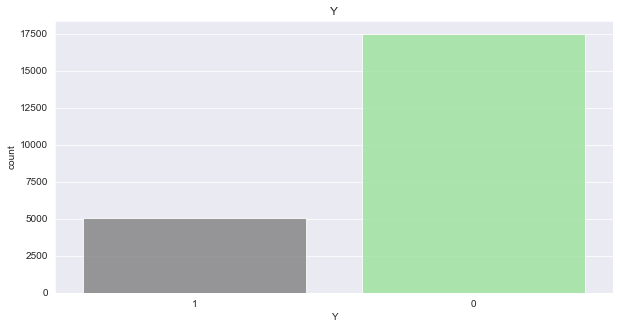

In [19]:
# Target Variable Countplot
sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
sns.countplot(df['Y'], alpha =.80, palette= ['grey','lightgreen'])
plt.title('Y')
plt.show()

## Models

Various models are created across multiple classifcation techniques in order to try and generate a model with the highest F1 score. For each type of model, a preliminary model is created as well as a model built using Grid Search to find the best parameters.

### Logistic Regression Models

**Preliminary Logistic Regression Model**

In [20]:
#instantiate and fit mmodel
logreg = LogisticRegression(random_state = 4, class_weight = 'balanced')
logreg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=4)

In [21]:
#predict with model
lg_pred_train = logreg.predict(X_train)
lg_pred_test = logreg.predict(X_test)

In [22]:
#get f1 scores
lg_train = f1_score(y_train, lg_pred_train, pos_label = '1')
lg_test = f1_score(y_test, lg_pred_test, pos_label = '1')

In [23]:
#create df of scores
scores = pd.DataFrame([['Logistic Regression', lg_train, lg_test]],
               columns = ['Model', 'Train', 'Test'])
scores

,Model,Train,Test
0,Logistic Regression,0.396536,0.37318


**Grid Search Logistic Regression Model**

In [24]:
#dict of parameters
grid = {'random_state': [4],
    'penalty':['l1', 'l2', 'elasticnet', None],
    'C': [.001, .01, .1, 1.0],
    'class_weight':['balanced'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

#instantiate and fit grid search
gs = GridSearchCV(estimator=logreg, param_grid=grid, cv=3, scoring = custom_scorer)
gs.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=4),
             param_grid={'C': [0.001, 0.01, 0.1, 1.0],
                         'class_weight': ['balanced'],
                         'penalty': ['l1', 'l2', 'elasticnet', None],
                         'random_state': [4],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring=make_scorer(f1_score, pos_label=1))

In [25]:
#get best parameters
gs.best_params_

{'C': 1.0,
 'class_weight': 'balanced',
 'penalty': 'l1',
 'random_state': 4,
 'solver': 'liblinear'}

In [26]:
#instantiate and fit best params model
gs_logreg = LogisticRegression(random_state = 4, 
                               class_weight = 'balanced', 
                               C = 1.0, 
                               penalty = 'l2', 
                              solver = 'liblinear')
gs_logreg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=4, solver='liblinear')

In [27]:
#predict with model
gs_lg_pred_train = gs_logreg.predict(X_train)
gs_lg_pred_test = gs_logreg.predict(X_test)

In [28]:
#get f1 scores
gs_lg_train = f1_score(y_train, gs_lg_pred_train, pos_label = '1')
gs_lg_test = f1_score(y_test, gs_lg_pred_test, pos_label = '1')

In [29]:
#add scores to df
gs_lg_model = pd.DataFrame([['Grid Search Logistic Regression', gs_lg_train, gs_lg_test]],
               columns = ['Model', 'Train', 'Test'])
scores = scores.append(gs_lg_model, ignore_index = True)
scores

,Model,Train,Test
0,Logistic Regression,0.396536,0.373180
1,Grid Search Logistic Regression,0.534077,0.516277


### KNN

**Preliminary KNN Model**

In [30]:
#instantiate and fit model
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [31]:
#predict with model
knn_pred_train = knn.predict(X_train)
knn_pred_test = knn.predict(X_test)

In [32]:
#get f1 scores
knn_train = f1_score(y_train, knn_pred_train, pos_label = '1')
knn_test = f1_score(y_test, knn_pred_test, pos_label = '1')

In [33]:
#add scores to df
knn_model = pd.DataFrame([['KNN', knn_train, knn_test]],
               columns = ['Model', 'Train', 'Test'])
scores = scores.append(knn_model, ignore_index = True)
scores

,Model,Train,Test
0,Logistic Regression,0.396536,0.373180
1,Grid Search Logistic Regression,0.534077,0.516277
2,KNN,0.430023,0.248096


**Preliminary KNN SMOTE Model**

A KNN model with SMOTE accounting for class imbalance is created to try and improve the F1 score.

In [34]:
#apply SMOTE
sm = SMOTE(random_state=4)
X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)

In [35]:
#instantiate and fit model
knn_sm = KNeighborsClassifier()
knn_sm.fit(X_train_smote, y_train_smote)

KNeighborsClassifier()

In [36]:
#predict with model
knn_sm_pred_train = knn_sm.predict(X_train_smote)
knn_sm_pred_test = knn_sm.predict(X_test)

In [37]:
#get f1 score
knn_sm_train = f1_score(y_train_smote, knn_sm_pred_train, pos_label = '1')
knn_sm_test = f1_score(y_test, knn_sm_pred_test, pos_label = '1')

In [38]:
#add scores to df
knn_sm_model = pd.DataFrame([['KNN SMOTE', knn_sm_train, knn_sm_test]],
               columns = ['Model', 'Train', 'Test'])
scores = scores.append(knn_sm_model, ignore_index = True)
scores

,Model,Train,Test
0,Logistic Regression,0.396536,0.373180
1,Grid Search Logistic Regression,0.534077,0.516277
2,KNN,0.430023,0.248096
3,KNN SMOTE,0.856384,0.367676


**Grid Search KNN SMOTE Model**

In [39]:
#get dict of parameters
knn_grid = {
    'n_neighbors':[3,5,11,19],
    'weights':['uniform','distance'],
    'metric':['euclidean','manhattan']
}

#instantiate Grid Search model
knn_gs = GridSearchCV(estimator=knn_sm, param_grid = knn_grid, verbose=1 ,cv=3, n_jobs = -1, scoring = custom_scorer)

In [40]:
#fit GridSearch model
knn_gs.fit(X_train_smote, y_train_smote)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 32.8min finished


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 11, 19],
                         'weights': ['uniform', 'distance']},
             scoring=make_scorer(f1_score, pos_label=1), verbose=1)

In [41]:
knn_gs.best_estimator_

KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')

In [42]:
#instantiate and fit best params model
gs_knn_sm = KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')
gs_knn_sm.fit(X_train_smote, y_train_smote)

KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')

In [43]:
#predicgt with model
gs_knn_sm_pred_train = gs_knn_sm.predict(X_train_smote)
gs_knn_sm_pred_test = gs_knn_sm.predict(X_test)

In [44]:
#get f1 score
gs_knn_sm_train = f1_score(y_train_smote, gs_knn_sm_pred_train, pos_label = '1')
gs_knn_sm_test = f1_score(y_test, gs_knn_sm_pred_test, pos_label = '1')

In [45]:
#add scores to df
gs_knn_sm_model = pd.DataFrame([['Grid Search KNN SMOTE', gs_knn_sm_train, gs_knn_sm_test]],
               columns = ['Model', 'Train', 'Test'])
scores = scores.append(gs_knn_sm_model, ignore_index = True)
scores

,Model,Train,Test
0,Logistic Regression,0.396536,0.373180
1,Grid Search Logistic Regression,0.534077,0.516277
2,KNN,0.430023,0.248096
3,KNN SMOTE,0.856384,0.367676
4,Grid Search KNN SMOTE,0.999656,0.348407


### Decision Tree

**Preliminary Decision Tree Model**

In [46]:
#instantiate and fit model
tree = DecisionTreeClassifier(random_state = 4, class_weight = 'balanced') 
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=4)

In [47]:
#predict with model
dt_pred_train = tree.predict(X_train)
dt_pred_test = tree.predict(X_test)

In [48]:
#get f1 score
tree_train = f1_score(y_train, dt_pred_train, pos_label = '1')
tree_test = f1_score(y_test, dt_pred_test, pos_label = '1')

In [49]:
#add scores to df
tree_model = pd.DataFrame([['Decision Tree', tree_train, tree_test]],
               columns = ['Model', 'Train', 'Test'])
scores = scores.append(tree_model, ignore_index = True)
scores

,Model,Train,Test
0,Logistic Regression,0.396536,0.373180
1,Grid Search Logistic Regression,0.534077,0.516277
2,KNN,0.430023,0.248096
3,KNN SMOTE,0.856384,0.367676
4,Grid Search KNN SMOTE,0.999656,0.348407
5,Decision Tree,0.998684,0.389431


**Grid Search Decision Tree**

In [50]:
#get dict of params
tree_params_grid ={
    'criterion':['gini', 'entropy'],
    'max_depth':[None, 5, 3, 2],
    'min_samples_split': [2,10,20],
    'random_state': [4], 
    'class_weight':['balanced']
}

#instantiate gridsearch
gs_tree = GridSearchCV(estimator = tree, param_grid = tree_params_grid, scoring = custom_scorer)

In [51]:
#fit grid search
gs_tree.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=4),
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 3, 2],
                         'min_samples_split': [2, 10, 20],
                         'random_state': [4]},
             scoring=make_scorer(f1_score, pos_label=1))

In [52]:
#instantiate and fit best params model
gs_tree_model = gs_tree.best_estimator_
gs_tree_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                       min_samples_split=20, random_state=4)

In [53]:
#predict with model
gstree_pred_train = gs_tree_model.predict(X_train)
gstree_pred_test = gs_tree_model.predict(X_test)

In [54]:
#get f1 scores
gs_tree_train = f1_score(y_train, gstree_pred_train, pos_label = '1')
gs_tree_test = f1_score(y_test, gstree_pred_test, pos_label = '1')

In [55]:
#add scores to df
gs_tree_model = pd.DataFrame([['Grid Search Decision Tree', gs_tree_train, gs_tree_test]],
               columns = ['Model', 'Train', 'Test'])
scores = scores.append(gs_tree_model, ignore_index = True)
scores

,Model,Train,Test
0,Logistic Regression,0.396536,0.373180
1,Grid Search Logistic Regression,0.534077,0.516277
2,KNN,0.430023,0.248096
3,KNN SMOTE,0.856384,0.367676
4,Grid Search KNN SMOTE,0.999656,0.348407
5,Decision Tree,0.998684,0.389431
6,Grid Search Decision Tree,0.539545,0.511298


### Random Forest Models

**Preliminary Random Forest Model**

In [56]:
#instantiate and fit model
forest = RandomForestClassifier(random_state = 4, class_weight = 'balanced')
forest.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=4)

In [57]:
#predict with model
forest_pred_train = forest.predict(X_train)
forest_pred_test = forest.predict(X_test)

In [58]:
#get f1 scores
forest_train = f1_score(y_train, forest_pred_train, pos_label = '1')
forest_test = f1_score(y_test, forest_pred_test, pos_label = '1')

In [59]:
#add scores to df
forest_model = pd.DataFrame([['Random Forest', forest_train, forest_test]],
               columns = ['Model', 'Train', 'Test'])
scores = scores.append(forest_model, ignore_index = True)
scores

,Model,Train,Test
0,Logistic Regression,0.396536,0.373180
1,Grid Search Logistic Regression,0.534077,0.516277
2,KNN,0.430023,0.248096
3,KNN SMOTE,0.856384,0.367676
4,Grid Search KNN SMOTE,0.999656,0.348407
5,Decision Tree,0.998684,0.389431
6,Grid Search Decision Tree,0.539545,0.511298
7,Random Forest,0.998815,0.469792


**Grid Search Random Forest Model**

In [62]:
#get dict of params
rf_param_grid = {
    'bootstrap': [True],
    'max_depth': [5, 10, 20, 50],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [50, 100, 200, 300],
    'random_state': [4], 
    'class_weight':['balanced']
}

#instantiate the grid search 
forest_grid_search = GridSearchCV(estimator = forest, param_grid = rf_param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring = custom_scorer)

In [63]:
#fit grid search
forest_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 12.2min finished


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=4),
             n_jobs=-1,
             param_grid={'bootstrap': [True], 'class_weight': ['balanced'],
                         'max_depth': [5, 10, 20, 50], 'max_features': [2, 3],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [50, 100, 200, 300],
                         'random_state': [4]},
             scoring=make_scorer(f1_score, pos_label=1), verbose=2)

In [64]:
#instantiate with best params model
gs_forest = forest_grid_search.best_estimator_

In [65]:
#fit with best params model
gs_forest.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=50, max_features=2,
                       min_samples_leaf=3, min_samples_split=12,
                       n_estimators=200, random_state=4)

In [66]:
#predict with model
gs_forest_pred_train = gs_forest.predict(X_train)
gs_forest_pred_test = gs_forest.predict(X_test)

In [67]:
#get f1 score
gs_forest_train = f1_score(y_train, gs_forest_pred_train, pos_label = '1')
gs_forest_test = f1_score(y_test, gs_forest_pred_test, pos_label = '1')

In [68]:
#add scores to df
gs_forest_model = pd.DataFrame([['Grid Search Random Forest', gs_forest_train, gs_forest_test]],
               columns = ['Model', 'Train', 'Test'])
scores = scores.append(gs_forest_model, ignore_index = True)
scores

,Model,Train,Test
0,Logistic Regression,0.396536,0.373180
1,Grid Search Logistic Regression,0.534077,0.516277
2,KNN,0.430023,0.248096
3,KNN SMOTE,0.856384,0.367676
4,Grid Search KNN SMOTE,0.999656,0.348407
5,Decision Tree,0.998684,0.389431
6,Grid Search Decision Tree,0.539545,0.511298
7,Random Forest,0.998815,0.469792
8,Grid Search Random Forest,0.639910,0.532659


The model with the highest F1 score on the test set is the Grid Search Random Forest Model. While some other models had higher F1 scores on the train set, they had lower F1 scores on the test data, signifying overfitting. 

## Final Model

The Grid Search Random Forest model is the final model picked based off the results above. This model has F1 scores of about 0.64 on the train data and 0.53 on the test data. This model is deemed the best model since this model gives the highest F1 score on the test data. 

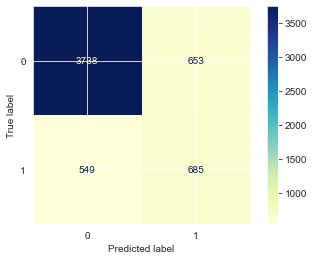

In [69]:
plot_confusion_matrix(gs_forest, X_test, y_test, cmap="YlGnBu");

## Next Steps

Further analysis could benefit from the following:
  - Engineering features in order to better predict if a customer with default
  - Adding more models such as a XGBoost model to try and generate a higher F1 score
  - Running model on more unseen data